In [43]:
import torch
from torch import nn
from torch import optim
from torchsummary import summary
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, random_split, DataLoader

import os
import yaml
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw
plt.ion()

from NeuralNetwork import Net

torch.manual_seed(0)
np.random.seed(0)

torch.cuda.get_device_name()

'GeForce RTX 2080 SUPER'

In [44]:
with open('hyperparameters.yaml') as f:
    hp = yaml.safe_load(f)['hyperparameters']

In [45]:
train_images = './data/melanoma/train/'
val_images = './data/melanoma/val/'
test_images = './data/melanoma/test/'

malignant = 'Melanoma/'
benign = 'NotMelanoma/'

(224, 224)
(224, 224)
(224, 224)


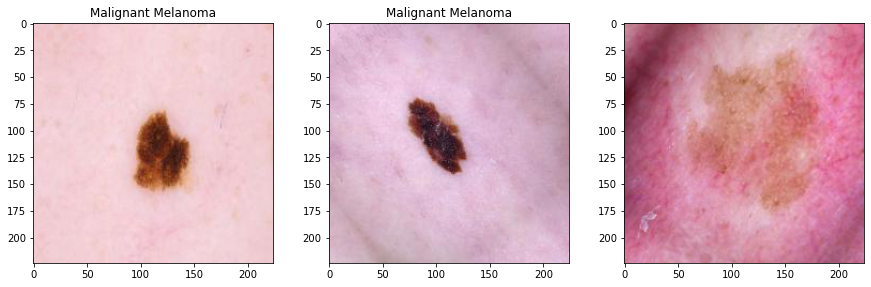

In [46]:
plt.rcParams['figure.figsize'] = (15., 15.)

for idx, filename in enumerate(os.listdir(os.path.join(train_images, malignant))[:3]):
    img = Image.open(os.path.join(train_images, malignant + filename))
    print(img.size)

    plt.title('Malignant Melanoma')
    plt.subplot(3, 3, idx + 1)
    plt.imshow(np.array(img))

(600, 450)
(600, 450)
(600, 450)


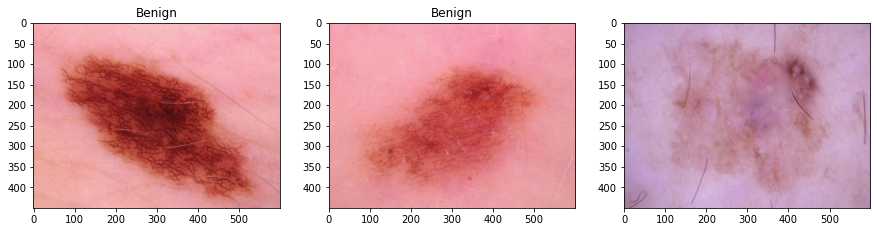

In [47]:
for idx, filename in enumerate(os.listdir(os.path.join(train_images, benign))[:3]):
    img = Image.open(os.path.join(train_images, benign + filename))
    print(img.size)

    plt.title('Benign')
    plt.subplot(3, 3, idx + 1)
    plt.imshow(np.array(img))

In [48]:
dataset_transforms = transforms.Compose([
    transforms.Resize((224, 224))
    , transforms.ToTensor()
])

train_ds = datasets.ImageFolder(root=train_images, transform=dataset_transforms)
val_ds = datasets.ImageFolder(root=val_images, transform=dataset_transforms)
test_ds = datasets.ImageFolder(root=test_images, transform=dataset_transforms)


In [49]:
print(train_ds[10000])

(tensor([[[0.5255, 0.5176, 0.5255,  ..., 0.5412, 0.5333, 0.5294],
         [0.5333, 0.5294, 0.5255,  ..., 0.5490, 0.5412, 0.5412],
         [0.5373, 0.5373, 0.5373,  ..., 0.5412, 0.5451, 0.5451],
         ...,
         [0.5608, 0.5569, 0.5608,  ..., 0.3451, 0.5137, 0.5451],
         [0.5569, 0.5608, 0.5647,  ..., 0.3647, 0.3608, 0.5176],
         [0.5569, 0.5569, 0.5608,  ..., 0.5020, 0.3294, 0.3843]],

        [[0.4824, 0.4824, 0.4863,  ..., 0.5059, 0.4941, 0.4941],
         [0.4902, 0.4941, 0.4941,  ..., 0.5176, 0.5059, 0.5020],
         [0.4941, 0.5020, 0.5020,  ..., 0.5176, 0.5137, 0.5098],
         ...,
         [0.5098, 0.5059, 0.5059,  ..., 0.2980, 0.4745, 0.5216],
         [0.5098, 0.5059, 0.5059,  ..., 0.3137, 0.3137, 0.4824],
         [0.5098, 0.5059, 0.5098,  ..., 0.4627, 0.2745, 0.3451]],

        [[0.5294, 0.5333, 0.5373,  ..., 0.5333, 0.5137, 0.5020],
         [0.5490, 0.5412, 0.5451,  ..., 0.5333, 0.5216, 0.5216],
         [0.5490, 0.5490, 0.5569,  ..., 0.5294, 0.5333, 0

In [50]:
print(train_ds.class_to_idx)

{'Melanoma': 0, 'NotMelanoma': 1}


In [51]:
train_batch_size = hp['train_batch_size']
val_batch_size = hp['val_batch_size']

train_dl = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=val_batch_size, shuffle=False)

In [52]:
for x, y in train_dl:
    x = x.shape
    print('TRAIN --')
    print(f'Batch size: {x[0]}, Channels: {x[1]}, Width: {x[2]}, Height: {x[3]}')
    print(f'Labels: {y}')
    break

TRAIN --
Batch size: 64, Channels: 3, Width: 224, Height: 224
Labels: tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0])


In [53]:
for x, y in val_dl:
    x = x.shape
    print('VAL --')
    print(f'Batch size: {x[0]}, Channels: {x[1]}, Width: {x[2]}, Height: {x[3]}')
    print(f'Lables: {y}')
    break

VAL --
Batch size: 32, Channels: 3, Width: 224, Height: 224
Lables: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [54]:
net = Net().cuda() # Net() can found in ./NeuralNetwork.py

In [55]:
net

Net(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1

In [56]:
summary(net, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
            Conv2d-2         [-1, 32, 112, 112]             288
       BatchNorm2d-3         [-1, 32, 112, 112]              64
              ReLU-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]           2,048
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]             576
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]           8,192
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
           Conv2d-14          [-1, 128,

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [58]:
def save_model(model, loss):
    print(f'WEIGHTS SAVED - LOSS: {loss} \n')
    torch.save(model, './models/melanoma_classification_weights.pt')

In [59]:
def batch_accuracy(out, target):
    out = out.argmax(dim=1)
    num_correct = out.eq(target.view_as(out)).sum().item()
    return num_correct, len(out)

In [60]:
history = {
    'train':{
        'accuracy': [],
        'loss': []
    },
    'val':{
        'accuracy': [],
        'loss': []
    }
}

In [61]:
def train(epoch):
    net.train()
    scheduler.step()
    for batch_idx, (data, target) in enumerate(train_dl):
        data, target = Variable(data), Variable(target)

        data = data.cuda()
        target = target.cuda()

        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        num_correct, size = batch_accuracy(output, target)
        accuracy = num_correct / size
        loss_item = loss.data.item()

        history['train']['accuracy'].append(accuracy)
        history['train']['loss'].append(loss_item)

        if (batch_idx + 1)% 100 == 0:
            print(f'Train Epoch: {epoch + 1} --> {(batch_idx + 1) * len(data)}/{len(train_dl.dataset)} '
                  f'({100.0 * (batch_idx + 1) / len(train_dl):.0f}%)\tLoss: {loss_item:.6f}')

In [62]:
global best_loss
best_loss = float('inf')

def evaluate(data_loader):
    net.eval()
    loss = 0
    correct = 0
    global best_loss

    for data, target in data_loader:
        data, target = Variable(data), Variable(target)

        data = data.cuda()
        target = target.cuda()

        output = net(data)

        loss += F.cross_entropy(output, target, size_average=False).data.item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    accuracy = correct / len(data_loader.dataset)
    loss /= len(data_loader.dataset)

    history['val']['accuracy'].append(accuracy)
    history['val']['loss'].append(loss)

    print(f'\nLoss: {loss:.4f} \t Val Accuracy: {correct}/{len(data_loader.dataset)} '
          f'({100.0 * correct / len(data_loader.dataset):.3f}%)')

    if loss < best_loss:
        best_loss = loss
        save_model(net, best_loss)

In [ ]:
epochs = hp['epochs']

for i in range(epochs):
    train(i)
    evaluate(val_dl)